<a href="https://colab.research.google.com/github/tkarani1/ML_HW5_AugKarani/blob/main/CS475_homework5_lab_sp22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 5: Unsupervised Learning: Image Segmentation Lab
### 25 points total
### Version 1.0



PARTNER1NAME (PARTNER1JHED), PARTER2NAME (PARTNER2JHED)

**Instructions:**
This notebook is intended to guide you through a real-world unsupervised learning task: image segmentation. Please answer all questions in this notebook (you will see <font color='blue'>TODO</font> annotations for where to include your answers). At the beginning of each part, we will bullet the expected deliverables for you to complete. All questions can be answered in 1-4 sentences, unless otherwise noted.

## Part 1: Defining the Problem and Choosing an Image
Things to do in this part:
1. Find a picture according to the instructions below
2. Complete questions 1-3

Your first task is to choose an image with a few discernible segments, or objects. This could be a picture of yourself with one or a few friends, a painting of a landscape with trees in the foreground and mountains in the background, or a photograph of your street with multiple distinct buildings in view.

The image does not have to be grayscale, but since we will ultimately be converting the image to grayscale for the purposes of this assignment, it should contain a reasonable amount of contrast between segments (you shouldn't have to squint to tell different objects in the image apart).

#### 1) Describe your image. Please address the following questions in your description:


*   What are the key components of the image that you pick out when you look at the image?
*   What objects sharply contrast with each other, and which do you think could be hard for a machine learning model to separate?
* Are there any objects you would anticipate a machine learning algorithm breaking up into multiple distinct segments? 
* How many distinct segments do you think would be maximally useful for summarizing the information in your image?

Please answer this question before grading your dataset: you will not be graded based on whether or not your model accurately picks up on the segments you discuss.

<font color='blue'>
    TODO: replace this cell with your answer
</font>

#### 2) Upload and view your image

You may use the following command to upload your image from your computer into Google Colab. Note that the file name on your local device will be maintained when you migrate the image to colab.

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving color.jpeg to color (1).jpeg


Now, we are going to use the Python Image Library (PIL) to view the image. The following command can be used to view a color image of Gilman Hall on the Homewood campus, which was uploaded with the file name `color.jpeg`. If your file had a different name, feel free to change the snippet below as needed. 

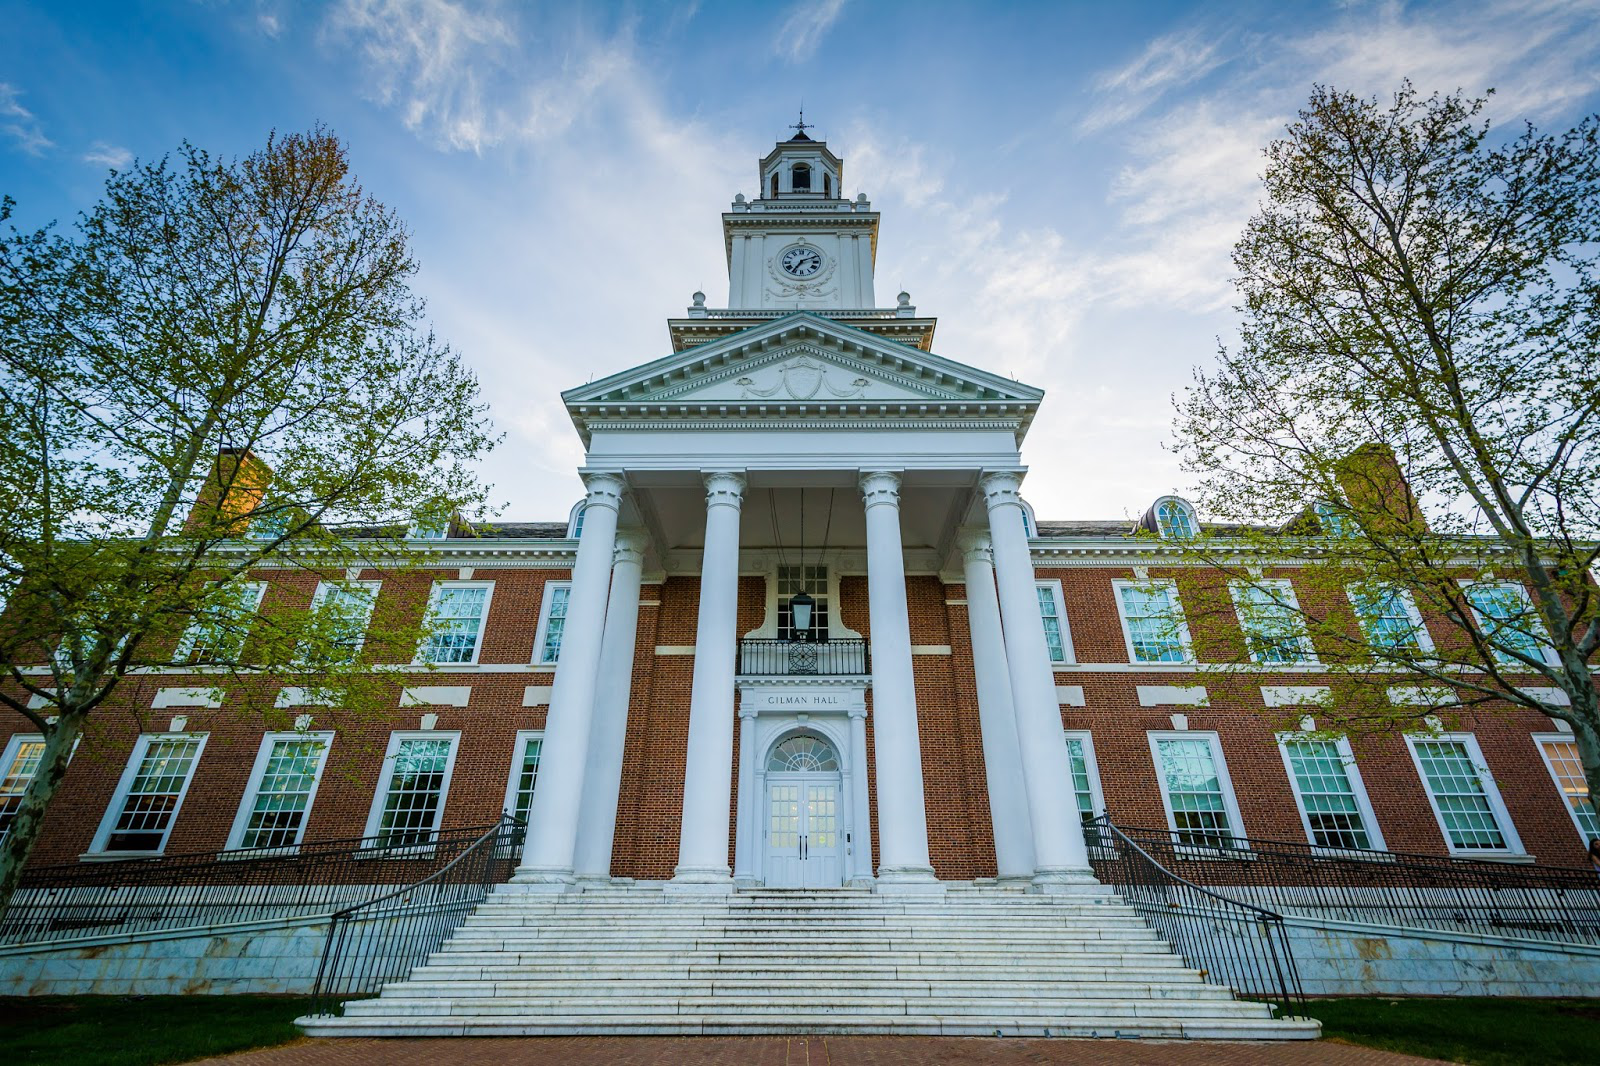

In [ ]:
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

color_image = Image.open('color.jpeg')
color_image

### 3) View a grayscale version of your image.
If your previous image was colorized, use the following code snippet to convert your image to grayscale and view it. We also recommend reducing the size of your file to improve runtime down the road. Here, we use about a 10x reduction in file size - you can set this to whatever you'd like, just be sure to keep this decision in mind when analyzing results.

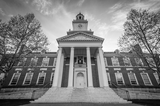

In [ ]:
grayscale_image = ImageOps.grayscale(color_image)
downsize_image = grayscale_image.resize((160, 106),Image.ANTIALIAS)
downsize_image

We can view the change in resolution by blowing the downsized file back up to scale. Feel free to play with the resolution as much as you want.

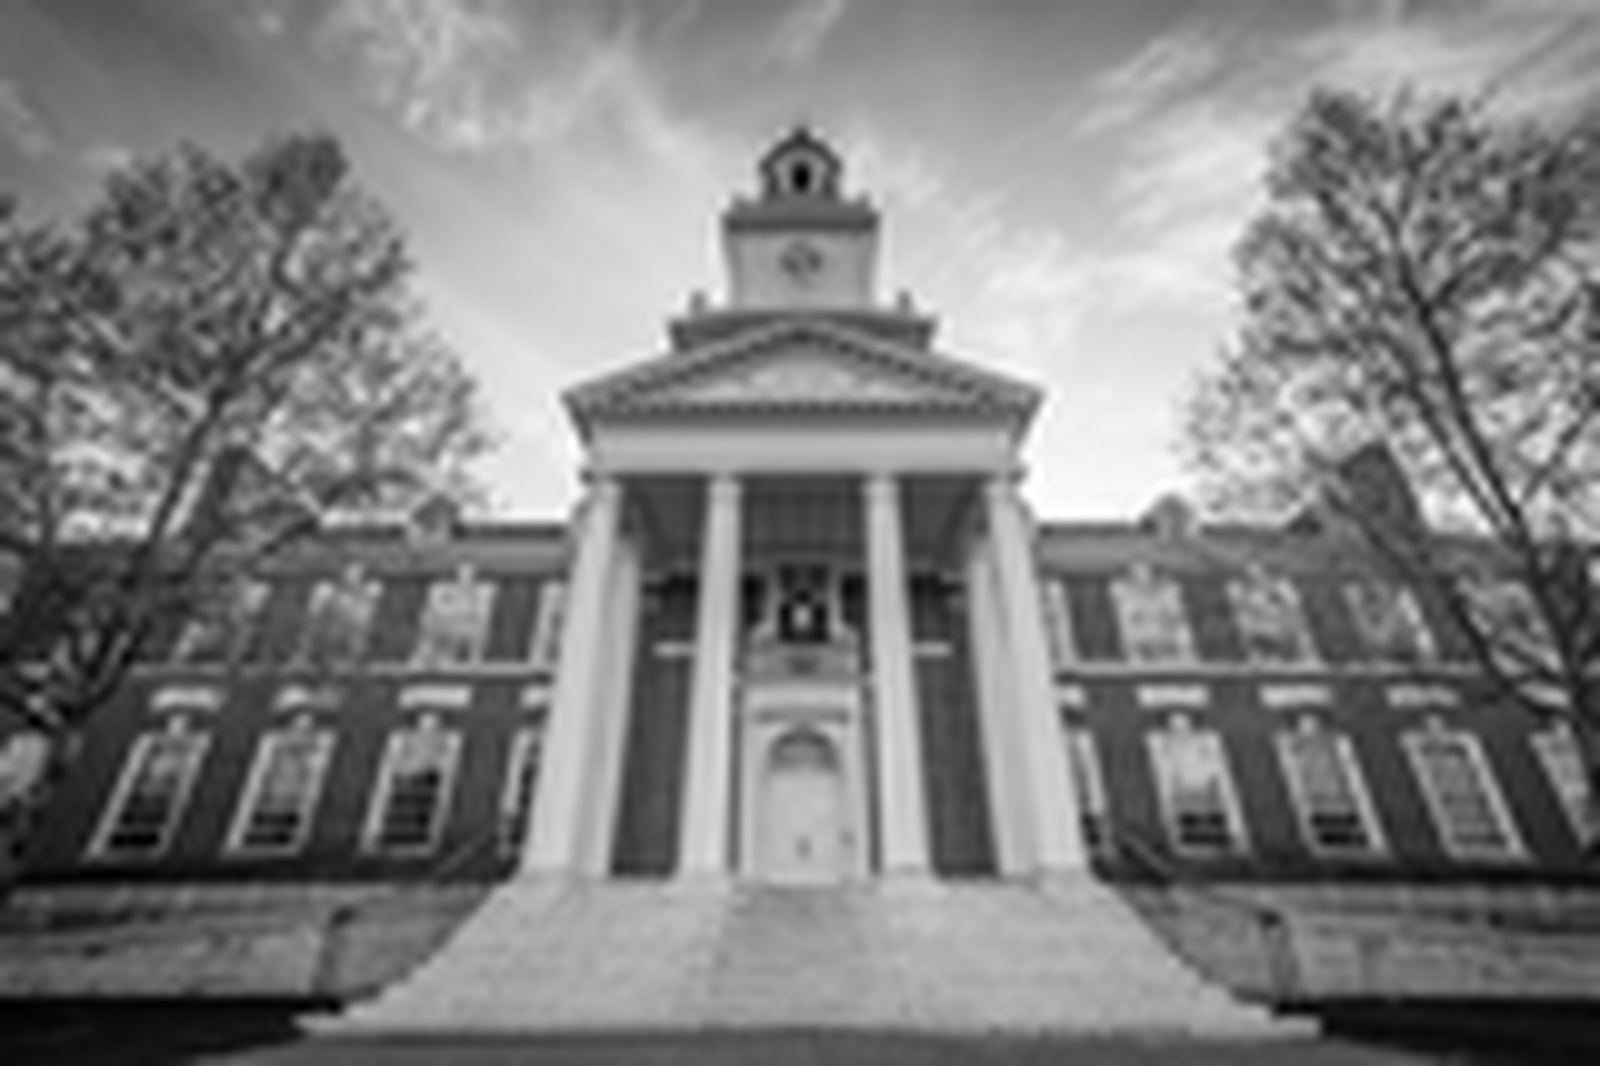

In [ ]:
blowup_image = downsize_image.resize((1600, 1066),Image.ANTIALIAS)
blowup_image

### 4) View and summarize the raw data

You may use the following command to convert your grayscale image to raw, numeric features encoding the grayscale value at each pixel.

In [ ]:
import numpy as np

image_mat = np.asarray(downsize_image)

Familiarize yourself with the raw data. You are only required to address at least the following points, but feel free to explore any additional features of your raw data that you think could influence the performance of an image segmentation algorithm. 
*   Print out a few rows or columns of the raw data.
*   What is the shape of the raw data?
*   What types of values (integers, real-valued number, letters) is the raw data allowed to take?
*   (If applicable) What is the minimum and maximum grayscale value in your image?

In [ ]:
## TODO: write any code needed for exploration of your raw data here

<font color='blue'>
    TODO: Replace this cell with your answer
</font>

## Part 2: Developing a baseline for comparison
Things to do in this part:
1. Answer questions 5-7

Before we present a simple unsupervised learning algorithm for image segmentation, let's develop a baseline for comparison by considering alternative approaches to the problem of image segmentation based on the other modeling approaches we have used this year.

### 5) Framing image segmentation as a supervised learning problem
In order to use supervised learning for image segmentation, we would need a dataset consisting of multiple data points, each of them containing a segment label.

*   Exactly how many labels would need to be produced to train a classifier to perform segmentation of the image you chose?
*   How could those labels be obtained?

<font color='blue'>
    TODO: Replace this cell with your answer
</font>

### 6) Framing image segmentation as a clustering problem

Recall that during the clustering breakout we demonstrated how clustering could be used for image *compression*, a task which bears some similarity to image segmentation. If we think of segments as groups of pixels with similar brightness levels, then we can use clustering to group pixels into segments based solely on their grayscale values. Since we are familiar with K-Means Clustering from earlier in the semester, let's use it as a baseline to assess the new method we're going to work with today.

Use the sklearn package to run KMeans clustering on your image. Note that in order to cluster every pixel, rather than every column or row of pixels, it may be necessary to reshape your image. Once you have assigned pixels to clusters and have a matrix of cluster assignments of the same shape as your original image, plot the result using the command provided.

In [ ]:
from sklearn.cluster import KMeans
import random

random.seed(42)
### TODO: run KMeans clustering here

In [ ]:
plt.imshow(kmeans.labels_.reshape(image_mat.shape))

#### 7) Describe the performance of your baseline. Address at least the following points in your response: 
* How did this clustering-based approach to image segmentation perform compared to your expectations? 
* Which objects are and are not discernible in the segmented image?
* Did the image segmentation algorithm uniquely assign different objects to their own segments? (If your image contains more than 2 objects, this question may have more than 2 answers)

<font color='blue'>
    TODO: replace this cell with your answer
</font>

## Part 3) Working with an undirected graphical model
Things to do in this part:
1. Read through the specification of the Potts model, which we will be working with for the remainder of this assignment. More information can be found in Kevin Murphy's *Machine Learning: A Probabilistic Perspective*, or his new (freely available) book, found [here](https://probml.github.io/pml-book/book2.html).
2. Answer questions 8 (note there is an a and b!) and 9

**Model Overview**
A Potts model (also known as an Ising model for the 2-state case), is a specific type of Markov Random Field (MRF) that assumes every pixel comes from one of $K$ discrete states. The Potts model assumes that the latent states of adjacent pixels are dependent on each other, as shown in the figure at [this link](https://www.cs.ubc.ca/~murphyk/MLbook/figReport-16-Aug-2012/pdfFigures/chaingraphLatticeXY.pdf) (courtesy of Kevin Murphy, *Machine Learning: A Probabilistic Perspective*) 

**Model Specification**  
*Observed variables*: $x_s \in \{0,...,255\}$ encodes intensity for each pixel $s$.  
*Latent variables*: $y_s \in \{1, 2, ..., K\}$ encodes the assignment of pixel $s$ to 1 of $K$ unobserved states.

**Edge structure and edge potentials**: As shown in the figure above, our graphical model contains edges connecting each latent variable $y_s$ to the latent variables corresponding to the adjacent pixels. We use the following potential function to encode this relationship between nodes (for an example of $K=3$ states):
$$ψ_{st}(y_s, y_t)=\left(\begin{array}{cc} 
e^J & 1 & 1 \\
1 & e^J & 1 \\
1 & 1 & e^J
\end{array}\right)$$
where $J$ is a hyperparameter that governs how much pressure latent variables are under to conform to the same state as their neighbors. This edge potential indicates that $\psi_{st}(y_s, y_t)=e^J$ if $y_s=y_t$, or it's equal to 1 otherwise.





#### 8) From potentials to priors.
Recall that generative models are models that not only assign labels to data, but they model a data-generative process (in this case, the prior probability of observing a particular configuration of latent states, $\bf y$). 

a) Given these edge potentials $\psi_{st}$...

*   What is $p(y_s \neq y_t)$, the prior probability that any two adjacent states will **not** be the same as each other (your answer should be a function of the hyperparameter $J$)?
*   What is the prior probability that any two adjacent states **will** be the same as each other?
* How do you think changing the hyperparameter $J$ will influence image segmentation?

<font color='blue'>
    TODO: replace this cell with your answer
</font>

b) Using factorization of our graphical model, derive an expression for the total prior probability $p({\bf y})$, describing the prior probability density over all possible segmentations of an image before seeing any image data.

<font color='blue'>
    TODO: replace this cell with your answer
</font>



**Emission probabilities**  
Now that we have defined our edge potentials, we can move on to defining our emission probabilities, the likelihood of observing a particular intensity given a particular latent state. We will use a simple Gaussian distribution to describe this relationship:
$$p(x_t|y_t=k, \mu, \sigma^2)=\mathcal{N}(\mu_k, \sigma_k^2)$$
In simple terms, each segment $k$ of our image produces pixels of average intensity $\mu_k$ (a model parameter we will need to learn), with variance $\sigma_k$ (another model parameter we will need to learn). 

#### 9) Answer the following questions specifically for the image you have chosen: 
* How many segments do you think your image contains? 
* How many pixels does your image have? 
* Given the model that we have just specified, how many latent variables would this model have when applied to your image? 
* How many parameters does it have to learn?

<font color='blue'>
    TODO: replace this cell with your answer
</font>


## Part 4) Inference with a graphical model
Things to do in this part:
1. Complete questions 10 through 15

#### 10) We are going to use expectation maximization to perform inference in this graphical model. To use EM in this case, what are we going to update in the E step? What about in the M step? (You do not need to derive updates, just a conceptual description about which aspects of our model undergo updates at which step). 

<font color='blue'>
    TODO: replace this cell with your answer
</font>


#### 10) Using the code that we have provided, perform image segmentation using variational inference, and display your segmented image as previously. Compare the results obtained using at least 2 different values for the hyperparameter $J$. Are your results sensitive to choice of this hyperparameter? 
(Though not required, you are very welcome to change anything else you want in the code: the number of EM iteractions, the number of variational inference iterations, optimizing the code [it is very possible to improve runtime], etc) 

In [ ]:
### RUN THIS BLOCK
### You are welcome to make edits, but can complete the required analysis leaving everything as-is


from scipy.stats import norm

def initialize_theta_parameters(K):
    """ Helper function to initialize theta before begining of EM.
    Args:
                K: The number of latent states in the MRF
    Returns:
                mu: A numpy vector of dimension [K] representing the mean for each of the K classes
                sigma: A numpy vector of dimension [K] representing the standard deviation for each of the K classes
    """
    mu = np.random.randint(10, 245, (K))
    sigma = np.zeros(K) + 10
    return mu, sigma

def initialize_model_params(num_rows, num_cols, num_states, J):
    """ Helper function to initialize model parameters & hyperparameters before begining of EM.
    Args:
                num_rows: Number of rows in the image (in px)
                num_cols: Number of columns in the image (in px)
                num_states: Number of states/ segments
                J: Hyperparameter
    Returns:
                mu: A numpy vector of dimension [K] representing the mean for each of the K classes
                sigma: A numpy vector of dimension [K] representing the standard deviation for each of the K classes
    """
    model_params = {}
    model_params['num_image_rows'] = num_rows
    model_params['num_image_cols'] = num_cols
    model_params['num_states'] = num_states
    model_params['J'] = J
    mu, sigma = initialize_theta_parameters(num_states)
    model_params['state_mean'] = mu
    model_params['state_sd'] = sigma
    return model_params

def compute_gaussian_likelihoods(model_params, image):
    """ Helper function to compute likelihood of the observed data given model parameters.
    Args:
                model_params: vector of model parameters as defined in `initialize_model_params`
                image: [num_rows * num_cols] matrix of grayscale values for each pixel in the image
    Returns:
                likelihoods: [num_rows * num_cols * num_states] matrix with entries p(x|z) for each possible latent state z
    """
    likelihoods = np.zeros((model_params['num_image_rows'], model_params['num_image_cols'], 
                            model_params['num_states']))
    for state_number in range(model_params['num_states']):
        likelihoods[:, :, state_number] = norm.pdf(image,
                                                   model_params['state_mean'][state_number],
                                                   model_params['state_sd'][state_number])
    return likelihoods

def initialize_variational_parameters(num_rows_of_image, num_cols_of_image, K):
    """ Helper function to initialize variational distributions before each E-step.
    Args:
                num_rows_of_image: Integer representing the number of rows in the image
                num_cols_of_image: Integer representing the number of columns in the image
                K: The number of latent states in the MRF
    Returns:
                q: 3-dimensional numpy matrix with shape [num_rows_of_image, num_cols_of_image, K]
     """
    q = np.random.random((num_rows_of_image, num_cols_of_image, K))
    normalizer = np.repeat(np.expand_dims(np.sum(q, axis=2), axis=2), repeats=K, axis=2)
    q_pdf = np.divide(q, normalizer)
    return q_pdf

def update_pixel_variational_prob(Q, likelihoods, row_num, col_num, num_states, J, image):
    factors = []
    neighbors = [(row_num, col_num+1), (row_num,col_num-1), (row_num+1, col_num), (row_num-1,col_num)]
    for state in range(num_states):
        factor = likelihoods[row_num, col_num, state]
        summer = 0
        for neighbor in neighbors:
            if neighbor[0] < 0 or neighbor[1] < 0 or neighbor[0] >= image.shape[0] or neighbor[1] >= image.shape[1]:
                continue
            summer = summer + Q[neighbor[0], neighbor[1], state]
        factor = factor*np.exp(summer*J)
        factors.append(factor)
    return factors/np.sum(factors)

def make_predictions(vi_posteriors, num_rows, num_cols):
    output = np.zeros((num_rows, num_cols))
    for row_num in range(num_rows):
        for col_num in range(num_cols):
            output[row_num, col_num] = np.argmax(vi_posteriors[row_num, col_num,:])
    return output

def vi(model_params, image, variational_iterations):
    """Implement E-Step with Variational Inference
    Args:
                model_params: vector of model parameters as defined in `initialize_model_params`
                image: [num_rows * num_cols] matrix of grayscale values for each pixel in the image
                variational_iterations: # variational iterations to perform
    Return: 
                Q: [num_rows * num_cols * num_states] posterior over latent states for each pixel in the image
    """
    likelihoods = compute_gaussian_likelihoods(model_params, image)
    # Initialize Q
    Q = initialize_variational_parameters(image.shape[0], image.shape[1], model_params['num_states'])
    # VI iterations
    for vi_iter in range(variational_iterations):
        Q_prev = np.copy(Q)
        for row_num in range(model_params['num_image_rows']):
            for col_num in range(model_params['num_image_cols']):
                Q[row_num, col_num, :] = update_pixel_variational_prob(Q, likelihoods, row_num, col_num, model_params['num_states'], model_params['J'], image)
    return Q
    
def m_step(model_params, vi_posteriors, image):
    """Implement M-Step
    Args:
                model_params: vector of model parameters as defined in `initialize_model_params`
                vi_posteriors: [num_rows * num_cols * num_states] posterior over latent states for each pixel in the image
                image: [num_rows * num_cols] matrix of grayscale values for each pixel in the image
    Return: 
                model_params: vector of model parameters with updated mean & variance for each latent state
    """
    for state_num in range(model_params['num_states']):
        model_params['state_mean'][state_num] = np.sum(image*(vi_posteriors[:,:,state_num]))/np.sum(vi_posteriors[:,:,state_num])
        var = np.sum((np.square(image - model_params['state_mean'][state_num]))*(vi_posteriors[:,:,state_num]))/np.sum(vi_posteriors[:,:,state_num])
        model_params['state_sd'][state_num] = np.sqrt(var)
    return model_params

class MRF(object):
    def __init__(self, J, K, n_em_iter, n_vi_iter):
        self.J = J
        self.K = K
        self.n_em_iter = n_em_iter
        self.n_vi_iter = n_vi_iter
    def fit(self, *, X):
        """ Fit the model.
                Args:
                X: A matrix of floats with shape [num_rows_of_image, num_cols_of_image]
        """
        model_params = initialize_model_params(X.shape[0], X.shape[1], self.K, self.J)
        for em_iteration in range(self.n_em_iter):
            print(f"EM Iteration {em_iteration}\n")
            # E Step
            vi_posteriors = vi(model_params, X, self.n_vi_iter)
            # M Step
            model_params = m_step(model_params, vi_posteriors, X)
        self.model_params = model_params
    def predict(self, X):
        """ Predict.
        Args:
                X: A matrix of floats with shape [num_rows_of_image, num_cols_of_image]

        Returns:
                A matrix of ints with shape [num_rows_of_image, num_cols_of_image].
                    - Each element of this matrix should be the most likely state according to the trained model for the pixel corresponding to that row and column
                    - States should be encoded as {0,..,K-1}
        """
        vi_posteriors = vi(self.model_params, X, self.n_vi_iter)
        predicted_values = make_predictions(vi_posteriors, X.shape[0], X.shape[1])
        return predicted_values.astype(int)

In [ ]:
potential_param = 1.1 # model hyperparameter - tweak this
n_states = 4 # number of states

potts = MRF(J=potential_param, K=n_states, n_em_iter=10, n_vi_iter=10)

In [ ]:
potts.fit(X=image_mat)

In [ ]:
plt.imshow(potts.predict(image_mat))

#### 11) Compare the segmentation obtained using the Potts Model compare to that obtained using our K-Means clustering baseline 
* Be specific with regard to assessment of the segments you expected to see in your own image
* Do the segments detected match what you expected to see?
* Are some objects now more clearly segmented than others?

<font color='blue'>
    TODO: Replace this cell with your answer
</font>

#### 12) What modeling decisions made by the Potts model seem more appropriate for the task of image segmentation than K-means clustering? Are there any potential advantages of K-means clustering compared to the Potts model?

<font color='blue'>
    TODO: Replace this cell with your answer
</font>

#### 13) Name at least one aspect of the Potts model you think could limit its performance for image segmentation (you are encouraged to consider the specification of graph structure, edge potentials and emission probabilities that we described above).

<font color='blue'>
    TODO: Replace this cell with your answer
</font>

#### 14) You are working with an interdisciplinary team to decide on an approach to image segmentation that will play a part in your company's image processing pipeline. Many of your team members have little to no experience with machine learning. You have been tasked with choosing whether K-means or the Potts model is best suited for tasks like segmenting the image that you have chosen. In 3-5 sentences, select **one** of the two models and explain your decision to a non-technical audience.

<font color='blue'>
    TODO: Replace this cell with your answer
</font>

## Submit
Great work! You're all done.

Make sure to submit this Python notebook (as a PDF) and the dataset you created as a zip file. See the homework writeup for directions.